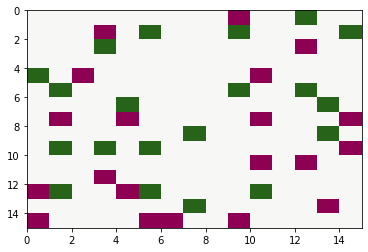

In [1]:
#Oppgave 1 a) og b)
from numba import jit
import numpy as np
import matplotlib.pyplot as plt


def generate_grid_of_monomers(N,M):
    grid = np.zeros((N, N), dtype=np.dtype('i2')) #lager et grid av riktig størrelse fylt av nuller
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #velger tilfeldig koordinat
        while grid[randomPosition] != 0:  #hvis koordinatet ikke er opptatt setter vi en positiv monomer der, til vi har M stk
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = i+1
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #så det samme for negative monomerer
        while grid[randomPosition] != 0:
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = -(i+1)
    return grid
    

def visualize_grid(grid, cmap='PiYG', low_val = -1, high_val = 1): #viser by default kun farger for verdier mellom -1 og 1
    plt.pcolormesh(grid,cmap=cmap, vmin = low_val, vmax = high_val)
    plt.gca().invert_yaxis() #plotter i matrisekoordinater

N, M = 15, 20
Example_system = generate_grid_of_monomers(N,M)
visualize_grid(Example_system)

In [2]:
@jit(nopython=True)
def get_neighbors_coordinates(N, i, j):
    neighborarray = [[i, (j-1)%N],
                     [i, (j+1)%N],
                     [(i-1)%N, j],
                     [(i+1)%N, j]]
    return neighborarray

@jit(nopython=True)
def get_neighboring_monomers(grid, N, i, j):
    neighborarray = get_neighbors_coordinates(N, i, j)
    for neighbor in neighborarray:
        if grid[neighbor[0],neighbor[1]]==0:
            neighborarray.remove(neighbor)
    return neighborarray
print(get_neighboring_monomers(Example_system, N, 8, 11))

[[8, 12], [9, 11]]


In [3]:
alpha_1 = ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(23E-6)**2)
@jit(nopython=True)
def energy_calculation(grid, N, alpha = alpha_1): #grid er gridet som blir generert gjennom monomer_grid
    energy = 0
    monomers = []
    for i in range(len(grid[0])):
        for j in range(len(grid[i])):
            if grid[i][j] != 0:
                monomers.append([i, j])
    for monomer in monomers:
        i,j = monomer[0], monomer[1]
        for neighbor in get_neighboring_monomers(grid, N, i, j):
            sign = grid[neighbor[0], neighbor[1]]*grid[i, j]
            if sign < 0:
                sign = -1
            elif sign > 0:
                sign = 1
            energy += sign #summerer opp monomer energy
            #returnerer E/alpha dvs antall interaksjoner mellom monomerer (negativ for forskjellig fortegn)
    return float(energy*alpha/2) #deler på 2 fordi vi itererer over alle monomerer og det er 2 monomerer i enhver interaksjon

In [4]:
# We use the convention for directions: 0 = left, 1= right, 2=up, 3=down
# If we try to move monomers on top of a different monomer, nothing happens (This is an illegal move)
@jit(nopython=True)
def move_monomer_fast(grid, monomer_value, direction, N):
    for i in range(len(grid[0])):
        for j in range(len(grid[i])):
            if grid[i][j] == monomer_value:
                monomer_coordinates = [i, j]
            else:
                pass
    
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0
    return grid

In [5]:
@jit(nopython=True)
def monte_carlo_energy(N_s, N, M, T, grid,alpha = alpha_1):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    epsilon = np.zeros(N_s, dtype=np.dtype('f8'))
    for i in range(N_s):
        E = energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid= grid.copy()
        new_grid = move_monomer_fast(new_grid, sign*magnitude, random_direction, N) # This function already avoids illegal moves
        E_new = energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass
        epsilon[i] = float(E/alpha)
    return epsilon, grid

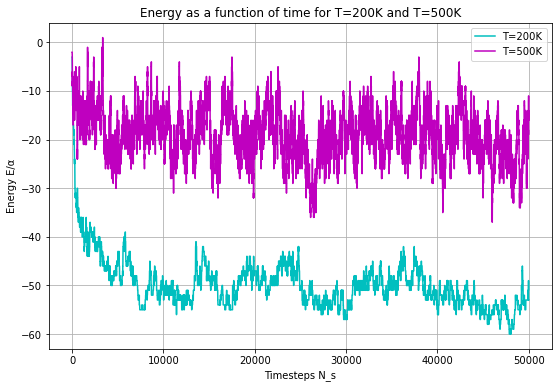

'We find that timesteps needed to reach equilibrium is at approximately 5000 steps for T=500K and at approx 20000 steps\nfor T=200K.'

In [6]:
N,M = 15, 25
N_s=50000
grid=generate_grid_of_monomers(N,M)
T_1=200
T_2=500
timesteps = np.arange(N_s)
low_T_energy, low_T_grid = monte_carlo_energy(N_s, N, M, T_1, grid)
np.savez('lowTsimulation.npz', low_T_grid=low_T_grid)

high_T_energy, high_T_grid = monte_carlo_energy(N_s, N, M, T_2, grid)

plt.figure(figsize=(9,6))
plt.title('Energy as a function of time for T=200K and T=500K')
plt.plot(timesteps, low_T_energy, 'c')
plt.plot(timesteps, high_T_energy, 'm')
plt.legend(['T=200K','T=500K'])
plt.grid(True)
plt.xlabel('Timesteps N_s')
plt.ylabel('Energy E/α')
plt.show()

'''t_equil is smaller for higher teperatures as the likelihood of monomers moving away from local minima is larger,
i.e. monomers move more frequently and also settle in a equilibrium faster, but this equilibrium has a higher potential energy
than the low temperature variant because the temperature (by definition) increases the energy of the system. In the high T 
simulation the monomers move more easily away from "bonds" with other monomers, this is the reason for the higher potential 
energy. For the lower temperature simulation this takes more moves to accomplish, as the probability of the low 
temperature grid being in a local equilibrium is larger than for the high temperature grid.'''

'''We find that timesteps needed to reach equilibrium is at approximately 5000 steps for T=500K and at approx 20000 steps
for T=200K.'''

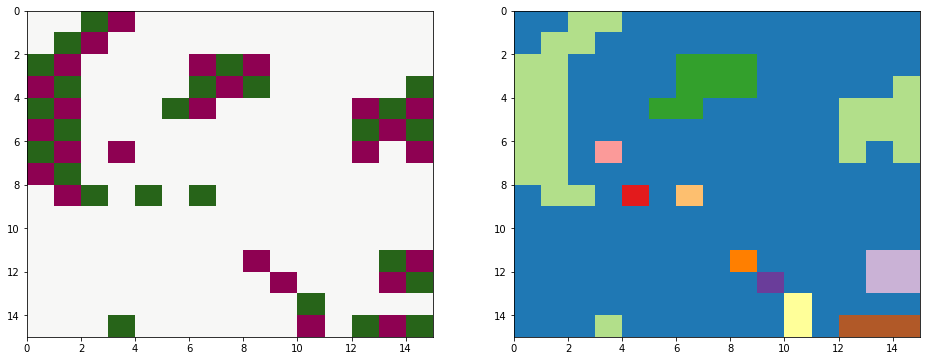

In [7]:
#Oppgave 1 g)
@jit(nopython=True)
def generate_cluster_grid(grid, M):
    largest_possible_cluster_value = 2*M
    cluster_number = largest_possible_cluster_value + 1
    cluster_grid = np.copy(grid) #unngår å endre på grid andre steder i koden
    #nummererer cluster og gir hvert cluster et nummer som garantert er høyere enn hvis alle monomerer er adskilt
    for monomer in np.argwhere(cluster_grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        cluster_grid[i][j] = cluster_number #lager nytt cluster
        cluster_number += 1
        nearest_neighbors = get_neighboring_monomers(grid, N, i, j)
        for neighbor in nearest_neighbors:
            if(abs(cluster_grid[neighbor[0]][neighbor[1]])<abs(cluster_grid[i][j])):
                if (cluster_grid[neighbor[0]][neighbor[1]]>=largest_possible_cluster_value):
                #hvis naboen er del av et cluster allerede får monomeren naboens verdi
                    for cluster_item in np.argwhere(cluster_grid == cluster_grid[i][j]):
                    #for alle monomerer i andre cluster som monomeren er en del av
                        cluster_grid[cluster_item[0],cluster_item[1]] = cluster_grid[neighbor[0]][neighbor[1]]
                    cluster_number -= 1
            else:
                for cluster_item in np.argwhere(cluster_grid == cluster_grid[neighbor[0]][neighbor[1]]):
                    #for alle monomerer i andre cluster som naboen er en del av
                        cluster_grid[cluster_item[0],cluster_item[1]] = cluster_grid[i][j]
                    
                '''merger cluster ved å gi alle monomerer i clusteret med høyest verdi verdien til det clusteret
                som er "eldst", dvs. lavest cluster verdi over 2, hvis ikke naboen er del av et eksisterende cluster,
                legger vi til naboen i monomerens cluster'''
    for monomer in np.argwhere(cluster_grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        cluster_grid[i][j] -= largest_possible_cluster_value #gir clusterne lavest mulig verdi
    return cluster_grid


lowTgrid = np.load('lowTsimulation.npz')['low_T_grid']
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
visualize_grid(lowTgrid)
plt.subplot(1,2,2)
visualize_grid(generate_cluster_grid(lowTgrid, M), cmap = 'Paired', high_val = None)
plt.show()

In [8]:
@jit(nopython=True)
def mean_cluster_size(cluster_grid, M):
    amount_of_clusters = 1
    for row in cluster_grid:
        for i in row:
            if i > amount_of_clusters: #clusters are numbered so largest number in grid = amount of clusters
                amount_of_clusters = i
    return 2*M/amount_of_clusters

In [9]:


alpha_1 = ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(23E-6)**2)

@jit(nopython=True)
def monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid,alpha = alpha_1):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    t_equil = int(t_equil)
    N_s = t_equil + t_r*n #Total time steps are steps until equilibrium plus steps between measurements times n measurements
    cluster_sizes = []
    
    for i in range(int(N_s)):
        if(i>=t_equil):
            if((i - t_equil)%(t_r)==0):
                current_mean_cluster_size = mean_cluster_size(generate_cluster_grid(grid, M), M)
                cluster_sizes.append(current_mean_cluster_size)
            else:
                pass
        else:
            pass
        E = energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid = np.copy(grid)
        new_grid = move_monomer_fast(new_grid, sign*magnitude, random_direction, N) # This function already avoids illegal moves
        E_new = energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass
    return sum(cluster_sizes)/n #the estimator (avg.) for the cluster size at given T
    

In [30]:
t_max = 15000
s = 1/200
C = 10000
T_l = 100
T_h = 1000
t_r = 1000
n = 100

temperatures = np.linspace(T_l, T_h,10)
equilibriums = []
for T in temperatures:
    equilibriums.append(t_max*np.exp(-s*(T-T_l)) + C)

In [31]:
N, M = 15, 25
    
mean_cluster_size_list = np.zeros(10)
grid=generate_grid_of_monomers(N,M)
for i in range(10):
    T, t_equil = temperatures[i], equilibriums[i]
    mean_cluster_size_list[i] = monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid)

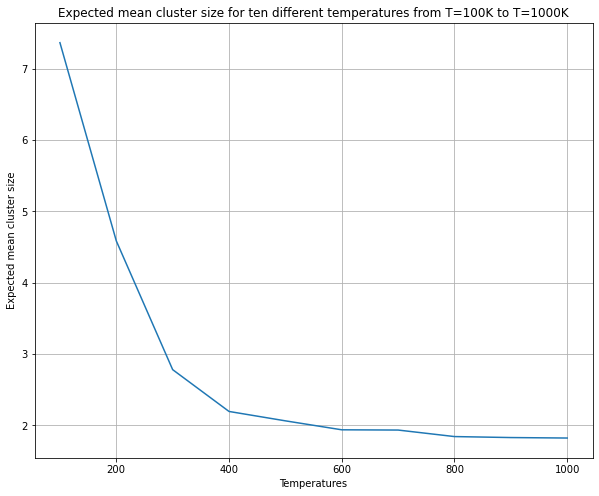

In [32]:
plt.figure(figsize=(10,8))
plt.title('Expected mean cluster size for ten different temperatures from T=100K to T=1000K')
plt.plot(temperatures, mean_cluster_size_list)
plt.grid(True)
plt.xlabel('Temperatures')
plt.ylabel('Expected mean cluster size')
plt.show()

In [33]:
N, M = 15, 25
    
mean_cluster_size_list = np.zeros(10)
grid=generate_grid_of_monomers(N,M)
for i in range(10):
    T, t_equil = temperatures[i], equilibriums[i]
    mean_cluster_size_list[i] = monte_carlo_cluster(t_equil, t_r, n, N, M, T, grid)

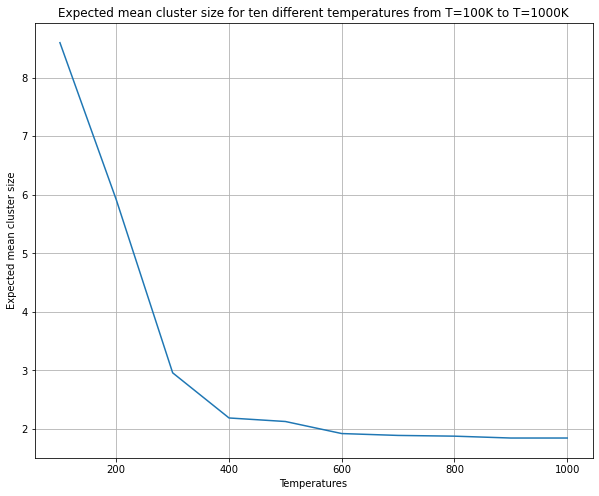

In [34]:
plt.figure(figsize=(10,8))
plt.title('Expected mean cluster size for ten different temperatures from T=100K to T=1000K')
plt.plot(temperatures, mean_cluster_size_list)
plt.grid(True)
plt.xlabel('Temperatures')
plt.ylabel('Expected mean cluster size')
plt.show()

In [29]:
'''<d> is larger at smaller T as the probalilty of a monomer moving away from even the weakest bond at T=100K is
less than 2%, while for the highest temperature T=1000K the probability of escaping the strongest possible bond
is about 30%, this means that the likelihood of larger clusters forming is quite small as the bonds get very weak at high 
temperatures (measured by the probability of monomers escaping bonds). Initially we thought that high energy simulations would 
be more efficient as they are less likely trapped in local minima, therefore we were initially surprised by the results. 
Using an n=100 should give us a valid result as the standard error decreases proportional to 1/sqrt(n). Both simulations give 
us a similar decrease in cluster size as temperature increases, which looks to be roughly hyperbolic. As mentioned lower 
temperatures have a larger probability of being trapped at local minima so the variation in lower temperatures should depend 
on chance at a much higher degree than higher temperature simulations. This is the reason for the larger variation at low 
temperatures, the initial conditions decide much of the final configuration, but for higher temperatures the configuration at 
equilibrium will be very similar independent of initial conditions.'''

'''These are equivalent to probabilities of monomers escaping bonds with 3 or 1 neighbors of opposite sign, for T=100K 
and T=1000K respectively.
'''
print(np.exp(-3*alpha_1/(100*1.380649E-23)))
print(np.exp(-alpha_1/(100*1.380649E-23)))
print(np.exp(-3*alpha_1/(1000*1.380649E-23)))
print(np.exp(-alpha_1/(1000*1.380649E-23)))

5.29049124052194e-06
0.017424700947186386
0.29672189912401165
0.6669857160743088


In [ ]:
#Oppgave 2 a)
alpha_2= ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(91E-6)**2)
def generate_grid_of_polymers(N,M,L):
    